# Digit recognizer

In [1]:
### Importing libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import tensorflow as tf
from time import time
tf.logging.set_verbosity(tf.logging.INFO) # DEBUG,WARN,INFO,FATAL,ERROR

pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
### Importing MNIST dataset
train=pd.read_csv("train.csv")
train=train.astype(float)
test=pd.read_csv("test.csv")
test=test.astype(float)

In [64]:
### Splitting the training data
evl=train.iloc[:37000,:]
evl2=train.iloc[37000:,:]

### Splitting labels and features
evl_l=evl["label"].astype(int)
evl_f=evl.iloc[:,1:]

evl2_l=evl2["label"].astype(int)
evl2_f=evl2.iloc[:,1:]

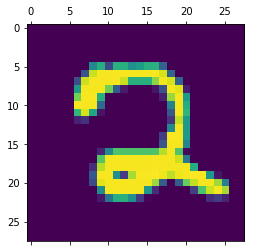

In [4]:
### Showing random example
random=np.random.randint(len(evl_f)-1)
_, ax = plt.subplots()
ax.matshow(evl_f.iloc[random,:].values.reshape(28, 28))
ax.grid(False)

### Convolutional neural network

In [5]:
def create_training_input_fn(features2,labels2,batch_size,epochs=None):
    def _input_fn():
        idx=np.random.permutation(features2.index.values)
        features=features2.reindex(idx)
        features={"pixels":features}
        labels=np.array(labels2[idx])
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size).repeat(epochs)
        ds=ds.shuffle(40000)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [48]:
def create_predict_input_fn(features2,labels2,batch_size):
    def _input_fn():
        features={"pixels":features2}
        labels=np.array(labels2)
        
        ds=tf.data.Dataset.from_tensor_slices((features,labels))
        ds=ds.batch(batch_size)
        
        feature_batch,label_batch=ds.make_one_shot_iterator().get_next()
        return feature_batch,label_batch
    return _input_fn

In [7]:
feature_column=[tf.feature_column.numeric_column(key="pixels",shape=[784])]

In [8]:
def my_model(features,labels,mode):
    input_layer= tf.reshape(features["pixels"], [-1, 28, 28, 1])
    conv1=tf.layers.conv2d(inputs=input_layer,filters=32,kernel_size=(5,5),padding="same",activation=tf.nn.relu)
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
    conv2 = tf.layers.conv2d(inputs=pool1,filters=64,kernel_size=[5, 5],padding="same",activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])
    dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)
    logits = tf.layers.dense(inputs=dropout, units=10)
    predicted_classes = tf.argmax(logits, 1)  
    
    predictions = {
            'class_ids': predicted_classes[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits, name="softmax_tensor"),
            'logits': logits
    }
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
        train_op = optimizer.minimize(loss=loss,global_step=tf.train.get_global_step())
        logging_hook=tf.train.LoggingTensorHook(tensors={"classes":predicted_classes},every_n_iter=100)
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op,training_hooks=[logging_hook]) 
    
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["class_ids"])
    }   
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [62]:
def train_model(train_f,train_l,evl_f,evl_l,batch_size,steps,parts):
    clf=tf.estimator.Estimator(model_fn=my_model,model_dir="C:\Python27\Digit_recognizer\Log")
    
    for p in range(parts):
        start=p*len(train_f)/parts
        end=(p+1)*len(train_f)/parts
        print("Training on data %i till %i" %(start,end))
        train_f_p=train_f.iloc[int(start):int(end),:]
        train_l_p=train_l.iloc[int(start):int(end)]
    
        train_input_fn=create_training_input_fn(features2=train_f_p,labels2=train_l_p,batch_size=batch_size)
        clf.train(input_fn=train_input_fn,steps=steps)
    
        evl_input_fn=create_predict_input_fn(features2=evl_f,labels2=evl_l,batch_size=1)
        print("Evaluation after training on data till %i" %(end))
        clf.evaluate(input_fn=evl_input_fn)

    return clf

In [63]:
clf2=train_model(evl_f,evl_l,evl2_f,evl2_l,5,3000,10)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Python27\\Digit_recognizer\\Log', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001F3212B82E8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training on data 0 till 500
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Python27\Digit_recognizer\Log\model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:

In [ ]:
print("Starting predictions..")

In [56]:
predict_input_fn=create_predict_input_fn(test.iloc[0:10,:],test.iloc[0:10],1)
pred=clf.predict(input_fn=predict_input_fn)
outcome=[]
for i in pred:
    outcome.append(i["class_ids"][0])
outcome=np.array(outcome)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Python27\Digit_recognizer\Log\model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
sample=pd.read_csv("sample_submission.csv")
sample["Label"]=outcome
sample.to_csv("Submission.csv",index=False)

In [ ]:
print("Done")